# Tests

In [1]:
Threads.nthreads()

4

In [2]:
using LinearAlgebra
using Turing
using LimberJack
using PythonCall
using NPZ
using BenchmarkTools;

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423
    CondaPkg Found dependencies: /home/jaime/.julia/environments/v1.7/CondaPkg.toml
    CondaPkg Found dependencies: /home/jaime/.julia/packages/PythonCall/DqZCE/CondaPkg.toml
    CondaPkg Resolving changes
             + libstdcxx-ng
             + python
    CondaPkg Installing packages


  Package              Version  Build               Channel                    Size
─────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────

  + lz4-c                1.9.3  h9c3ff4c_1          conda-forge/linux-64     Cached
  + olefile               0.46  pyh9f0ad1d_1        conda-forge/noarch       Cached
  + sqlite              3.39.4  h4ff8645_0          conda-forge/linux-64      807kB
  + unicodedata2        15.0.0  py39hb9d737c_0      conda-forge/linux-64      512kB
  + zlib                1.2.13  h166bdaf_4          conda-forge/linux-64     Cached

  Change:
─────────────────────────────────────────────────────────────────────────────────────

  - camb                 1.3.6  py311h9e0c992_1     conda-forge              Cached
  + camb                 1.3.6  py39hea1df8f_1      conda-forge/linux-64      978kB
  - fftw                3.3.10  nompi_hf0379b8

In [3]:
np = pyimport("numpy");

In [8]:
meta = np.load("../data/DECALS_KiDS//DECALS_KiDS_meta.npz")
files = npzread("../data/DECALS_KiDS/DECALS_KiDS_files.npz")

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"])
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [9]:
path = "/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_K1000_all_mag_correctMag/"
pars = np.loadtxt(string(path, "cl_cross_corr_v3_DES_K1000_all_mag_correctMag.bestfit"))
pars = pyconvert(Vector{Float64}, pars);

In [10]:
errs = sqrt.(diag(cov_tot))
fake_cov = cov_tot ./ (errs * errs')

470×470 Matrix{Float64}:
  1.0          -0.0685604    -0.00208283   …  -0.000131686  -0.000123508
 -0.0685604     1.0          -0.0500614       -0.000101157  -9.59531e-5
 -0.00208283   -0.0500614     1.0             -7.99092e-5   -7.59672e-5
  0.0275553    -0.00187172   -7.80379e-5      -0.000113982  -0.000106948
 -0.00149903    0.0268935    -0.00136412      -9.78903e-5   -9.28258e-5
 -6.22778e-5   -0.00135929    0.0259581    …  -7.88726e-5   -7.49306e-5
 -8.15428e-5   -6.01765e-5   -0.00108624      -6.42487e-5   -6.07085e-5
 -6.66308e-5   -6.76774e-5   -5.18636e-5      -5.5871e-5    -5.07485e-5
 -6.13519e-5   -5.46961e-5   -5.17573e-5      -4.96224e-5   -4.26242e-5
 -5.89764e-5   -4.96895e-5   -4.01327e-5      -4.41184e-5   -3.67261e-5
  0.000104516  -7.24679e-6   -2.98739e-7   …  -6.10764e-5   -5.72967e-5
 -5.6759e-6     0.000103921  -5.1625e-6       -5.63788e-5   -5.34177e-5
 -2.00351e-7   -4.42049e-6    9.71883e-5      -4.90023e-5   -4.64916e-5
  ⋮                                  

In [11]:
fake_inv_cov = pinv(fake_cov)

470×470 Matrix{Float64}:
  1.00558       0.0692102     0.00546866   …   0.000163576   0.000145217
  0.0692102     1.00815       0.0509812        0.00013426    0.000120279
  0.00546866    0.0509812     1.03978         -3.47217e-6   -3.30634e-6
 -0.0277252    -0.00153241   -0.000161143      0.000138787   0.000122643
 -0.00190865   -0.0270684    -0.00106974       0.000126202   0.000112414
 -0.000211981  -0.00106454   -0.0262185    …   5.30324e-7   -1.0084e-7
  0.000110154   6.29137e-5   -0.000774912      3.75923e-6    2.5578e-6
  8.75083e-5    7.299e-5     -0.00012004       5.42221e-6    4.15729e-6
  7.46639e-5    5.65558e-5   -6.94997e-5       7.86913e-6    6.22537e-6
  4.94346e-5    4.35201e-5   -4.20777e-5       9.68938e-6    7.61312e-6
  0.00138028    7.49535e-5   -1.53633e-5   …   7.13422e-5    6.27714e-5
  9.73699e-5    0.00134954    9.16804e-5       6.9348e-5     6.14665e-5
 -1.20114e-5    0.000140977  -3.27922e-5       2.60477e-6    1.72691e-6
  ⋮                                  

In [12]:
function get_theory(Ωm, s8;
                 data_vector=data_vector,
                 inv_cov=fake_inv_cov, 
                 tk_mode="emulator")
    
    nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31],
                     #"DECALS__0_0_dz" => pars[32],
                     #"DECALS__1_0_dz" => pars[33],
                     #"DECALS__2_0_dz" => pars[34],
                     #"DECALS__3_0_dz" => pars[35]
                     )
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    return theory

end

get_theory (generic function with 1 method)

In [28]:
fid_cosmo = Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                      tk_mode="emulator", Pk_mode="Halofit")
fid_nui =     nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31])
fid_data = Theory(fid_cosmo, tracers_names, pairs, idx, files;
                  Nuisances=fid_nui)

470-element Vector{Float64}:
 3.860786114543412e-5
 1.9496224132868983e-5
 1.2492804328858468e-5
 3.1860907383551587e-5
 2.0072168276602427e-5
 1.233418118687942e-5
 8.834930579127386e-6
 6.757245834702413e-6
 5.27539656285759e-6
 4.261998209356148e-6
 2.4726216881851362e-5
 1.5456535067600103e-5
 1.1058881421711052e-5
 ⋮
 8.362575708719529e-10
 7.188968492867564e-10
 6.187361549635061e-10
 5.330621005410856e-10
 4.5889125502352467e-10
 3.9438487462267643e-10
 3.3822269169416504e-10
 2.889502819694111e-10
 2.458619742086546e-10
 2.0824788342549605e-10
 1.7536293144344e-10
 1.467810883546799e-10

In [29]:
fake_data = (data_vector .- fid_data)./ errs

470-element Vector{Float64}:
 -0.2279206064972362
 -1.5127635937859012
 -2.65396432006937
 -0.672352659937609
 -2.399110688247009
 -0.9781607685331433
  0.5083413782636508
 -2.3876927025454835
 -0.8714452908960639
  0.13027698398807935
 -1.7490213686532095
 -1.3761346820011935
 -1.6044250642827804
  ⋮
  0.10135328479593864
 -1.557544496533692
 -1.1251842771967429
  0.013214662801050738
 -0.41948897195525353
  0.7519744073265955
 -0.2434933492338576
 -0.9623967527785772
  0.5142231202517356
  1.1577229376860818
  0.35207927649768095
 -0.34140738395970477

In [14]:
#ls_tot = []
#for l in 1:length([item for item in keys(files) if occursin("ls", item)])
#    t1, t2 = pairs[l][1], pairs[l][2]
#    append!(ls_tot, files[string("ls_", t1, "_", t2)])
#end
#fake_cov = Diagonal(@.((2*data_vector^2)/((2*ls_tot+1)*0.23)))
#fake_inv_cov = inv(fake_cov)

## 2D Lkl

In [33]:
function get_Xi2(Ωm, s8;
                 data=fake_data,
                 inv_cov=fake_inv_cov, 
                 tk_mode="emulator")
    nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31])
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    diff = @.(((theory .- fid_data)./ errs)-data)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [34]:
get_Xi2(0.3, 0.8)

537.6349094459204

In [35]:
Ωms = LinRange(0.1, 0.6, 20)
s8s = LinRange(0.60, 0.9, 20)

20-element LinRange{Float64, Int64}:
 0.6,0.615789,0.631579,0.647368,0.663158,…,0.852632,0.868421,0.884211,0.9

In [18]:
Xi2s_emul = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_emul[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="emulator")
    end
end

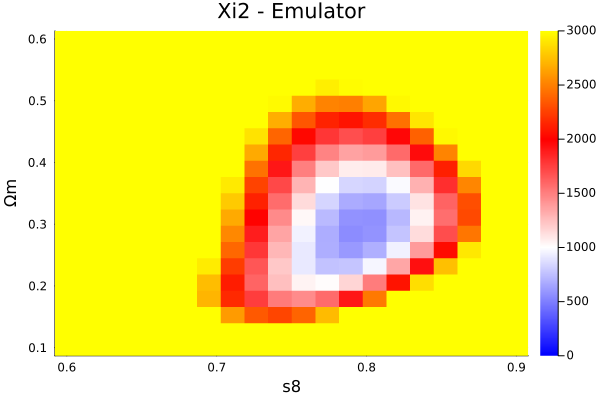

In [20]:
using Plots
gr()
heatmap(s8s, Ωms, Xi2s_emul,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8", clim=(0, 3000),
    title="Xi2 - Emulator")

## Turing

In [36]:
using Turing
@model function model(data;
                      tracers_names=tracers_names,
                      pairs=pairs,
                      idx=idx,
                      cov=fake_cov, 
                      files=files)
 
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb = 0.05 #~ Uniform(0.028, 0.065)
    h = 0.67 #~ Uniform(0.64, 0.82)
    s8 = 0.81 #~ Uniform(0.6, 0.9)
    ns = 0.96 #~ Uniform(0.84, 1.1)
    
    DECALS__0_0_b = 1.166 #~ Uniform(0.8, 3.0)
    DECALS__1_0_b = 1.399 #~ Uniform(0.8, 3.0)
    DECALS__2_0_b = 1.349 #~ Uniform(0.8, 3.0)
    DECALS__3_0_b = 1.823 #~ Uniform(0.8, 3.0)

    nuisances = Dict(
                     "DECALS__0_0_b" => DECALS__0_0_b,
                     "DECALS__1_0_b" => DECALS__1_0_b,
                     "DECALS__2_0_b" => DECALS__2_0_b,
                     "DECALS__3_0_b" => DECALS__3_0_b)

    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8,
                                     tk_mode="emulator",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    data_vector ~ MvNormal((theory .- fid_data)./errs , cov)
end;

In [37]:
cycles = 6
steps = 50
λ = 0.3
iterations = 100
TAP = 0.65
adaptation = 100
init_ϵ = 10^-7

1.0000000000000004e-7

In [38]:
chain = sample(model(fake_data), NUTS(adaptation, TAP),
                     iterations, progress=true; save_state=true)

┌ Info: Found initial step size
│   ϵ = 0.043750000000000004
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:41:18m


LoadError: InterruptException:

In [166]:
chain

LoadError: UndefVarError: chain not defined